<a href="https://colab.research.google.com/github/Romanvia93/traffic_sign_detection/blob/main/yolo/notebooks/Yolov5_w_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Traffic Sign Detection - YOLOv5 with image augmentation

In [ ]:
from zipfile import ZipFile
import os.path
from os import path

import xml.etree.ElementTree as ET
import os
from tqdm import tqdm
import pandas as pd

import numpy as np
from collections import defaultdict
import shutil

import matplotlib.pyplot as plt
from PIL import Image

import cv2
import random

import yaml

import seaborn as sns
%config InlineBackend.figure_format='retina'

In [ ]:
!pip install pybboxes

In [ ]:
import pybboxes as pbx
import gdown

## 1. Data

The dataset contains 4 categories:

| Category |
|:-|
|Traffic Light|
|Stop|
|Speed Limit|
|Crosswalk|

More details are provided at the annotation section.

In [ ]:
# Create new directory data/

if not os.path.exists("data"):
    os.mkdir("data")

# Download dataset to data/

%cd data
!gdown "https://drive.google.com/uc?export=download&id=1DgDd-PHRYb-y0FGDDXHKbi6ZaGoaTimB"

with ZipFile("archive.zip") as zipfile:
    zipfile.extractall()
!rm "archive.zip"


/content/data
Downloading...
From: https://drive.google.com/uc?export=download&id=1DgDd-PHRYb-y0FGDDXHKbi6ZaGoaTimB
To: /content/data/archive.zip
100% 229M/229M [00:07<00:00, 31.2MB/s]


## 2. Model

In [ ]:
# Go to root working directory

%cd ..

/content


In [ ]:
# clone yolov5 repo

!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 15871, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 15871 (delta 41), reused 41 (delta 8), pack-reused 15768
Receiving objects: 100% (15871/15871), 14.69 MiB | 17.43 MiB/s, done.
Resolving deltas: 100% (10850/10850), done.


In [ ]:
# install necessary libraries for yolov5

%cd ./yolov5
!pip install -r requirements.txt

/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.5/605.5 kB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.2 MB/s eta 0:00:00


## 3. Create annotations in YOLO format

In [ ]:
# Check current directory

!pwd

/content/yolov5


In [ ]:
# Go back to root working directory

%cd ..

/content


In [ ]:
# 1. Create new directory for annotations: data/annotations

annotations_path = ("data/annotations")
annotations = os.listdir(annotations_path)

In [ ]:
# 2. collect data from xml
img_name_list = []
width_list = []
height_list = []
label_list = []
xmin_list = []
ymin_list = []
xmax_list = []
ymax_list = []

for idx in tqdm(range(len(annotations))):

    tree = ET.parse(os.path.join(annotations_path, annotations[idx]))
    root = tree.getroot()

    img_name = root.find('filename').text

    size = root.find('size')
    width = size.find('width').text
    height = size.find('height').text

    for group in root.findall('object'):
        label = group.find('name').text
        bbox = group.find('bndbox')
        xmin = bbox.find('xmin').text
        ymin = bbox.find('ymin').text
        xmax = bbox.find('xmax').text
        ymax = bbox.find('ymax').text

        img_name_list.append(img_name)
        width_list.append(width)
        height_list.append(height)
        xmin_list.append(xmin)
        ymin_list.append(ymin)
        xmax_list.append(xmax)
        ymax_list.append(ymax)
        label_list.append(label)

100%|██████████| 877/877 [00:00<00:00, 5384.11it/s]


In [ ]:
# 3. save annotation data in required format
labels_df = pd.DataFrame({
                        'img_name': img_name_list,
                        'width': width_list,
                        'height': height_list,
                        'xmin': xmin_list,
                        'ymin': ymin_list,
                        'xmax': xmax_list,
                        'ymax': ymax_list,
                        'label': label_list})
labels_df.head()

,img_name,width,height,xmin,ymin,xmax,ymax,label
0,road39.png,320,400,89,9,218,366,trafficlight
1,road192.png,300,400,133,223,205,300,speedlimit
2,road875.png,300,400,50,248,61,261,speedlimit
3,road875.png,300,400,105,141,160,194,speedlimit
4,road875.png,300,400,164,267,178,284,stop


Label Counts
speedlimit      783
crosswalk       200
trafficlight    170
stop             91
Name: label, dtype: int64


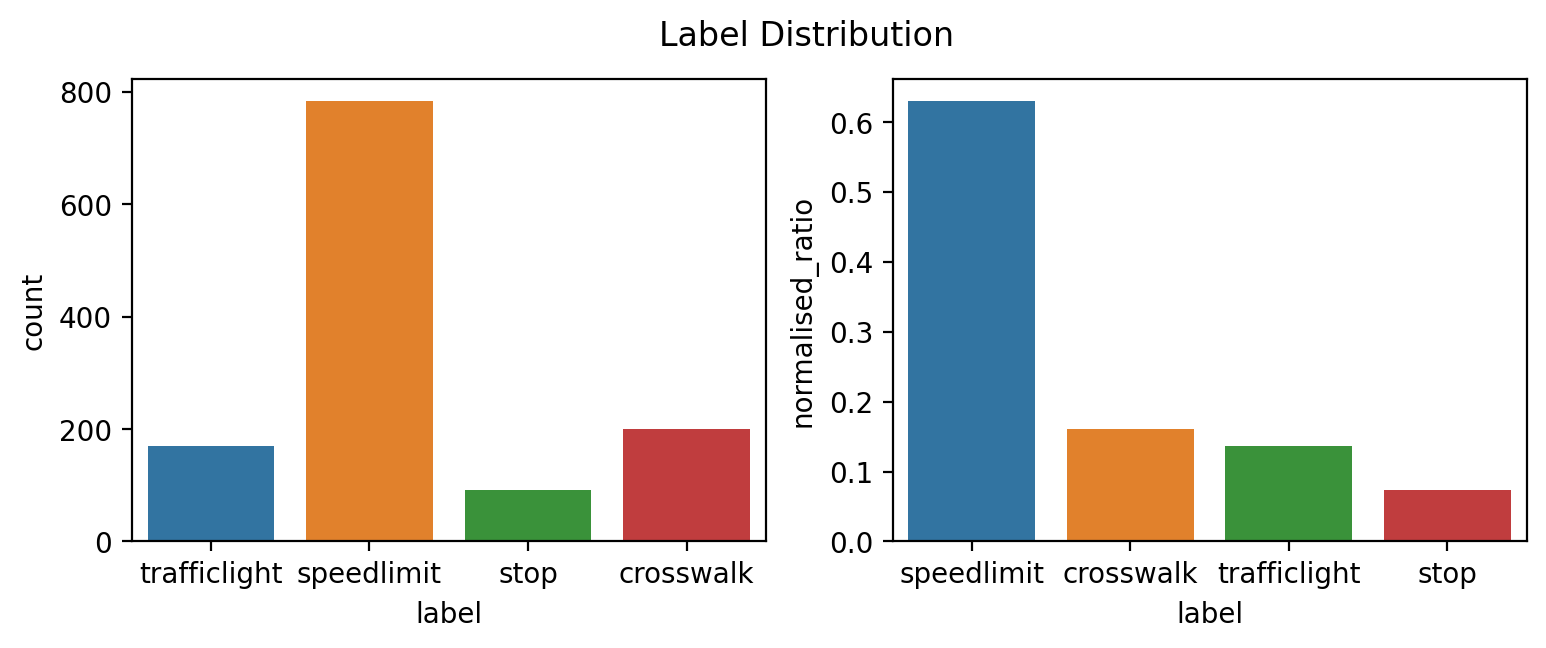

In [ ]:
def plot_label_distribution(data):

    print('Label Counts')
    print(data['label'].value_counts())
    fig, axes = plt.subplots(1, 2, figsize=(9, 3))
    fig.suptitle('Label Distribution')
    # Counts
    fig1 = sns.countplot(ax=axes[0], data=data, x='label', orient='v')
    # Normalize
    data_normalized = pd.DataFrame(data['label'].value_counts(1)).reset_index()
    data_normalized.columns = ['label', 'normalised_ratio']
    fig2 =sns.barplot(data=data_normalized, x='label', y='normalised_ratio')
    plt.show()

plot_label_distribution(labels_df)

In [ ]:
# 4. Determine labels
classes = labels_df['label'].unique().tolist()
labels_df['class'] = labels_df['label'].apply(lambda x: classes.index(x))
labels_df.head()

,img_name,width,height,xmin,ymin,xmax,ymax,label,class
0,road39.png,320,400,89,9,218,366,trafficlight,0
1,road192.png,300,400,133,223,205,300,speedlimit,1
2,road875.png,300,400,50,248,61,261,speedlimit,1
3,road875.png,300,400,105,141,160,194,speedlimit,1
4,road875.png,300,400,164,267,178,284,stop,2


In [ ]:
# 5. Generate dictionary where key is image_name and value is list of all bboxes information
img_dict = defaultdict(list)

for idx in tqdm(range(len(labels_df))):
    sample_label_list = []
    img_name = labels_df.loc[idx, 'img_name']
    xmin = labels_df.loc[idx, 'xmin']
    ymin = labels_df.loc[idx, 'ymin']
    xmax = labels_df.loc[idx, 'xmax']
    ymax = labels_df.loc[idx, 'ymax']
    class_num = labels_df.loc[idx, 'class']
    W, H = int(labels_df.loc[idx, 'width']), int(labels_df.loc[idx, 'height'])

    voc_bbox = (int(xmin), int(ymin) ,int(xmax), int(ymax))

    x_center, y_center, w, h = pbx.convert_bbox(voc_bbox, from_type="voc", to_type="yolo", image_size=(W,H))

    sample_label_list.append(str(class_num))
    sample_label_list.append(str(x_center))
    sample_label_list.append(str(y_center))
    sample_label_list.append(str(w))
    sample_label_list.append(str(h))
    line = ' '.join(sample_label_list)

    img_dict[img_name].append(line)

# example
print()
print(img_dict['road100.png'])

100%|██████████| 1244/1244 [00:00<00:00, 6973.15it/s]


['1 0.4975 0.42987012987012985 0.82 0.8337662337662337']


In [ ]:
# 6. make labels dir in data folder of yolov5
labels_dir = 'yolov5/data/labels'
if os.path.exists(labels_dir):
    shutil.rmtree(labels_dir)
os.mkdir(labels_dir)

In [ ]:
# 7. Generate .txt file for each image
for img_name, lines in img_dict.items():
    img_name = img_name.split('.')[0]
    with open(f'{labels_dir}/{img_name}.txt', 'w') as f:
        for line in lines:
            f.write(line)
            f.write('\n')

## 4. Prepare training data

### Train test split

In [ ]:
# 1. create train , val folders in data directory of yolov5
labels_path = labels_dir   ## directory having labels in .txt format

train_dir = 'yolov5/data/train'
val_dir = 'yolov5/data/val'

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)

os.mkdir(train_dir)
os.mkdir(val_dir)

# 2. train, val each containing images and labels folders
os.mkdir(train_dir + '/images')
os.mkdir(train_dir + '/labels')
os.mkdir(val_dir + '/images')
os.mkdir(val_dir + '/labels')

In [ ]:
images_path = 'data/images'
files = np.array(os.listdir(images_path))

In [ ]:
# 2. Function to prepare lists of file names
def split(files, ratio):
    np.random.seed(42)
    num_train = int(len(files) * ratio)
    train_files = np.random.choice(files, num_train, replace=False)
    val_files = np.setdiff1d(files, train_files)
    return train_files, val_files

# 3. Function to copy files to destinations
def copy_files(images_path, labels_path, destination_path, files):

    for file_name in files:
        file_name = file_name.split('.')[0]

        src = images_path + f'/{file_name}.png'
        dst = destination_path + '/images'
        shutil.copy(src, dst)

        src = labels_path + f'/{file_name}.txt'
        dst = destination_path + '/labels'
        shutil.copy(src, dst)

In [ ]:
# 4. Split and copy files in train and val folder
train_ratio = 0.8
train_files, val_files = split(files, train_ratio)

# 5. Copy files
copy_files(images_path, labels_path, train_dir, train_files)
copy_files(images_path, labels_path, val_dir, val_files)

In [ ]:
# 6. Check if everything is ok
assert (len(os.listdir(train_dir + '/images')) + len(os.listdir(val_dir + '/images')) == len(os.listdir(images_path)))

### Generate .yaml file for training

In [ ]:
with open(f'yolov5/data/sign_data.yaml', 'w') as f:
    f.write('train: ../data/train/images\n')
    f.write('val: ../data/val/images\n')
    f.write('nc: 4\n')
    f.write(f"names: {classes}")

## 5. Model training

In [ ]:
# 1. Go to yolov5/
%cd ./yolov5

/content/yolov5


### Augmentation

In [ ]:
# 2. Creat config file for augmentation

with open("data/hyps/hyp.no-augmentation.yaml") as f:
     list_doc = yaml.safe_load(f)

list_doc["scale"] = 0.5

with open("data/hyps/hyp.scale-augmentation.yaml", "w") as f:
    yaml.dump(list_doc, f)

### Training

In [ ]:
# 3. Train params

epochs = 29 #about 20000 images
!python train.py --img 640 --batch 4 --epochs {epochs} --data sign_data.yaml --hyp data/hyps/hyp.scale-augmentation.yaml --weights yolov5s.pt

WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")

train: weights=yolov5s.pt, cfg=, data=sign_data.yaml, hyp=data/hyps/hyp.scale-augmentation.yaml, epochs=29, batch_size=4, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, f

## 6. Validation

In [ ]:
# Check if we're in yolov5/ directory
!pwd

/content/yolov5


### mAP

Mean Average Precision Formula:  
$$
 mAP = \frac{1}{N}\sum\limits_{i=1}^N AP_i \\
$$
where AP = Average Precision

In [ ]:
# 1. Add path from results

exp = sorted(os.listdir('runs/train'))[-1]
exp_path = 'runs/train/' + exp

In [ ]:
# 2. Download result table
res = pd.read_csv(f"{exp_path}/results.csv")
res.columns = res.columns.str.strip()

# 3. Find the best model
res2 = res.iloc[res['metrics/mAP_0.5'].idxmax()]

# 4. save result
res_tab = pd.DataFrame({'model': 'yolov5',
#  'precision': res2['metrics/precision'],
#  'recall': res2['metrics/recall'],
 'mAP_0.5': res2['metrics/mAP_0.5'],
 'mAP_0.5:0.95': res2['metrics/mAP_0.5:0.95'],
}, index = [0])

res_tab

,model,mAP_0.5,mAP_0.5:0.95
0,yolov5,0.92355,0.74285


### Precision, Recall

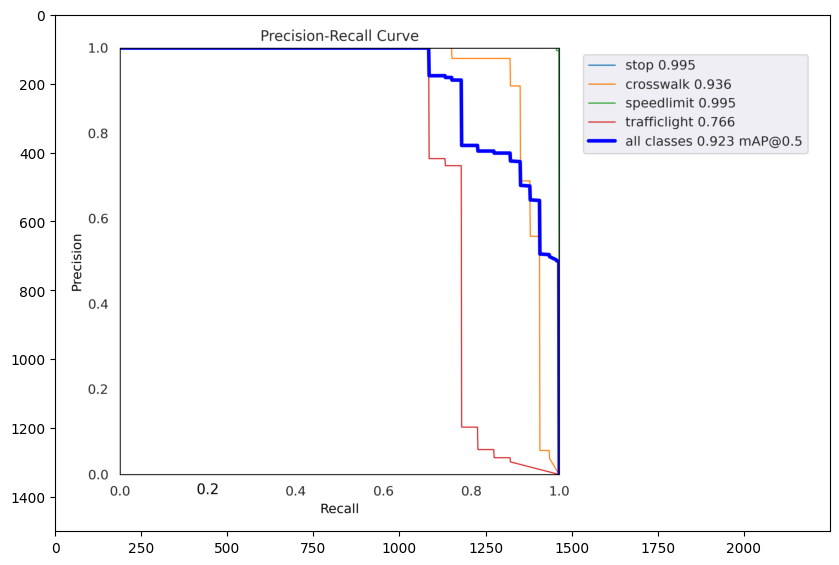

In [ ]:
pr_path = exp_path+'/PR_curve.png'
img = Image.open(pr_path)
plt.figure(figsize=(10, 10))
plt.imshow(img);

### Confusion matrix

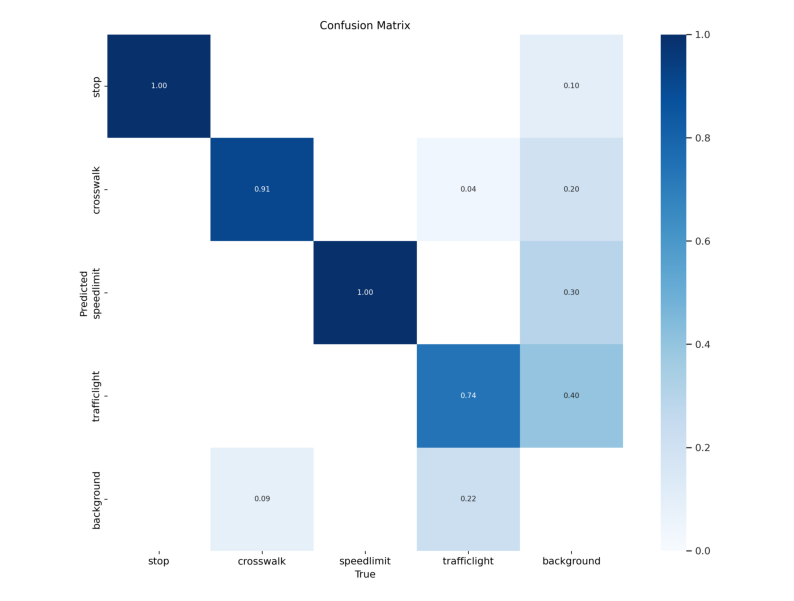

In [ ]:
cm_path = exp_path+'/confusion_matrix.png'
img = Image.open(cm_path)
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(img);

### Batch visualization

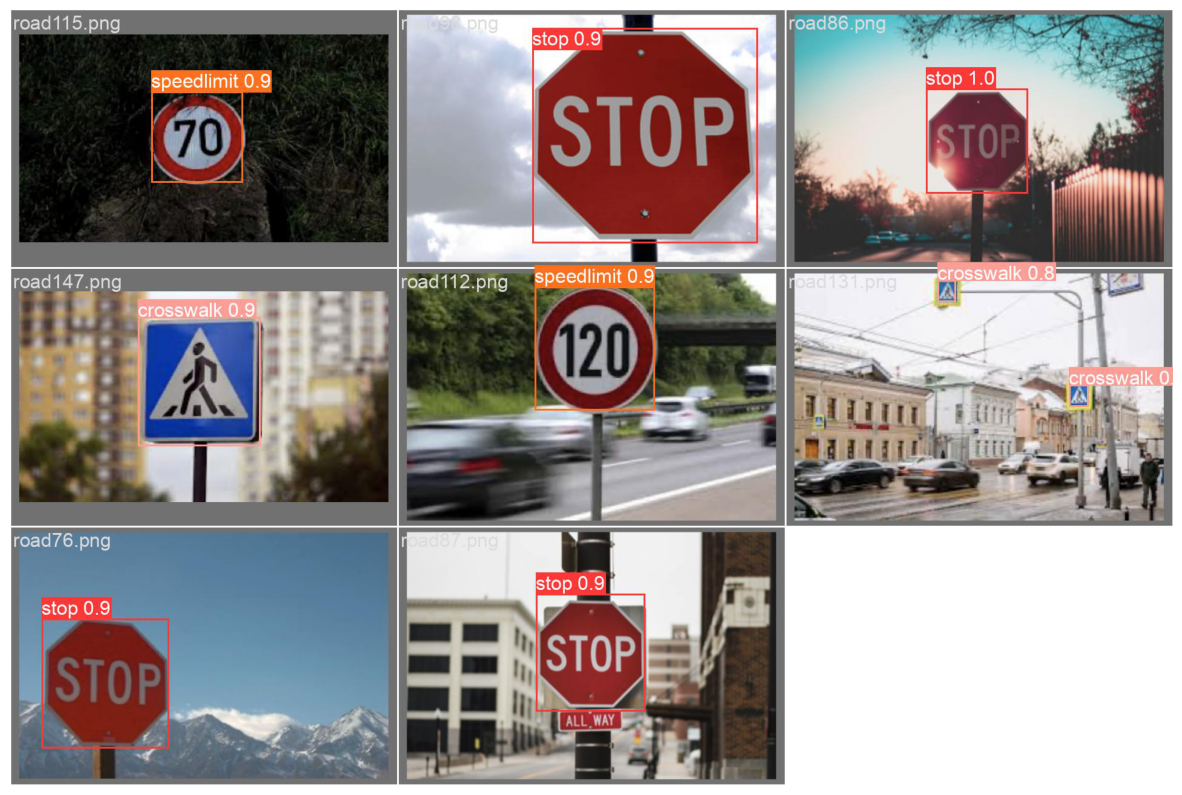

In [ ]:
# 2. Batch visualization
img_path = exp_path + '/val_batch0_pred.jpg'
img = Image.open(img_path)
plt.figure(figsize=(15, 15))
plt.axis("off")
plt.imshow(img);

## 7. Inference

### Download tuned weights

In [ ]:
# Go back to root working directory
%cd ..

/content


In [ ]:
# Create new directory to store weights: yolov5/tuned_weights
if not os.path.exists("yolov5/tuned_weights"):
    os.mkdir('yolov5/tuned_weights')

# Go to yolov5/tuned_weights
%cd yolov5/tuned_weights

/content/yolov5/tuned_weights


In [ ]:
!gdown "https://drive.google.com/uc?export=download&id=1HBvblhPPRR2fq2Wnnfm0GdvtQw0dZV2m"

Downloading...
From: https://drive.google.com/uc?export=download&id=1HBvblhPPRR2fq2Wnnfm0GdvtQw0dZV2m
To: /content/yolov5/tuned_weights/yolov5.pt
100% 14.4M/14.4M [00:00<00:00, 180MB/s]


### Infence on images

#### Preparing test images

In [ ]:
# Go back to root working directory
%cd ..
%cd ..

/content/yolov5
/content


In [ ]:
# Create new directory to store test images: test_images/
if not os.path.exists("test_images"):
    os.mkdir('test_images')

In [ ]:
# Go to test_images/
%cd test_images

/content/test_images


In [ ]:
# Download test images to test_images/

!gdown "https://drive.google.com/uc?export=download&id=1GG8l6W9U13G7Pq7NodSty6jcCmNALVmf"
!gdown "https://drive.google.com/uc?export=download&id=1Fd_qrsfrUtuJFpbBnd9C60hBPdbvVgzT"
!gdown "https://drive.google.com/uc?export=download&id=1GI74d5XWs3zcui6Eyv-HBZ91qlZT4qVf"
!gdown "https://drive.google.com/uc?export=download&id=1GNAdKNAGOGnQfwdSNWlpOnhqnZJOQB9q"

Downloading...
From: https://drive.google.com/uc?export=download&id=1GG8l6W9U13G7Pq7NodSty6jcCmNALVmf
To: /content/test_images/traffic_light.jpg
100% 62.6k/62.6k [00:00<00:00, 78.7MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1Fd_qrsfrUtuJFpbBnd9C60hBPdbvVgzT
To: /content/test_images/speed_limit.jpg
100% 184k/184k [00:00<00:00, 108MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1GI74d5XWs3zcui6Eyv-HBZ91qlZT4qVf
To: /content/test_images/stop.jpg
100% 240k/240k [00:00<00:00, 129MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1GNAdKNAGOGnQfwdSNWlpOnhqnZJOQB9q
To: /content/test_images/crosswalk.jpeg
100% 14.1k/14.1k [00:00<00:00, 45.6MB/s]


In [ ]:
# Go back to root working directory
%cd ..

/content


#### Detection

In [ ]:
# 1. Make detections on test images
!python yolov5/detect.py --weights yolov5/tuned_weights/yolov5.pt --img 640 --conf 0.5 --iou-thres 0.5 --source test_images --save-txt --save-conf

WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")

detect: weights=['yolov5/tuned_weights/yolov5.pt'], source=test_images, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_st

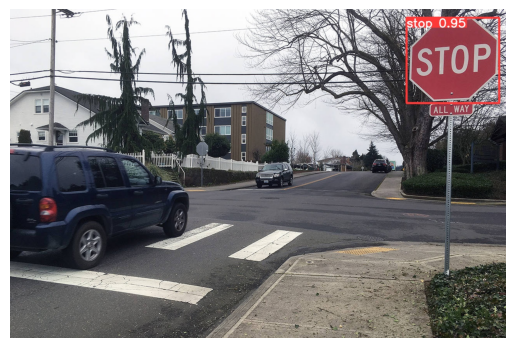

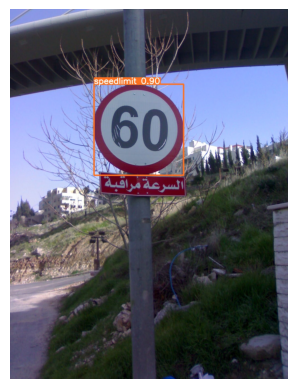

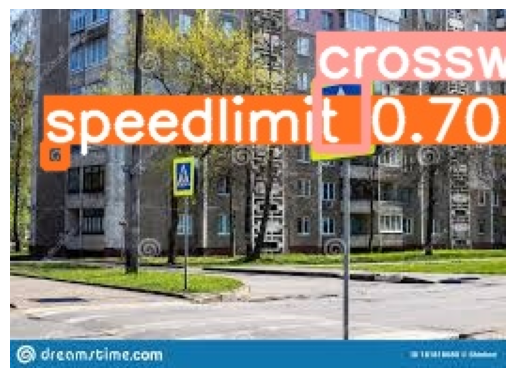

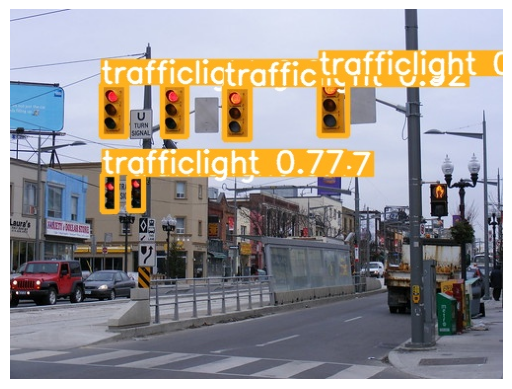

In [ ]:
# 2. Visualize

predicted_files = []
exp_path = "yolov5/runs/detect/exp"
for file_path in os.listdir(exp_path):
    if os.path.isfile(os.path.join(exp_path, file_path)):
        predicted_files.append(file_path)

for i in range(len(predicted_files)):
    file_name = predicted_files[i]
    detected_path= exp_path +"/"+ file_name
    detected_img=cv2.imread(detected_path)
    detected_img=cv2.cvtColor(detected_img,cv2.COLOR_BGR2RGB)

    plt.figure()
    plt.imshow(detected_img)
    plt.axis("off")

### Inference on videos

#### Prepare test video

In [ ]:
# Check current directory. Make sure we're in root working directory
!pwd

/content


In [ ]:
# Create a new directory to store test video: test_videos/
if not os.path.exists("test_videos"):
    os.mkdir('test_videos')

In [ ]:
# Go to test_videos/
%cd "test_videos"

/content/test_videos


In [ ]:
# Download test video to test_videos/
!gdown "https://drive.google.com/uc?export=download&id=1H1NX_eS4MJS_Gv3NP5SwT7rIMKBlDbn9"

Downloading...
From: https://drive.google.com/uc?export=download&id=1H1NX_eS4MJS_Gv3NP5SwT7rIMKBlDbn9
To: /content/test_videos/video.mp4
100% 4.71M/4.71M [00:00<00:00, 247MB/s]


In [ ]:
# Go back to root working directory
%cd ..

/content


#### Detection

In [ ]:
!python yolov5/detect.py --weights yolov5/tuned_weights/yolov5.pt --img 640 --conf 0.5 --iou-thres 0.5 --source test_videos/video.mp4 --save-txt --save-conf

WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")

detect: weights=['yolov5/tuned_weights/yolov5.pt'], source=test_videos/video.mp4, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.3, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=Fal

In [ ]:
# To view result, play the resulting video in the folder indicated right above